In [1]:
import compute_charge_dist as fz
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline

microntocm    = 1.0e-4
cmtomicron    = 1.0e4
AAtocm        = 1.0e-8
cmtoAA        = 1.0e8
microntoAA    = 1.0e4
AAtomicron    = 1.0e-4
ergtoeV       = 6.242e11
eVtoerg       = 1.602e-12

hplanck       = 4.135667662e-15 # eV s
clight        = 2.99792458e10   # cm s-1

Loading the library to compute the charge distribution of dust grains.


In [33]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

from scipy.optimize import curve_fit

import time

%matplotlib inline


grain_type = "silicate"
#grain_type = "carbonaceous"
pcent      = 1

########################################################################################

grain_size = 5

save_dir = "/home/jcibanezm/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 
#filename = "CompletenessCopy_0005AA_sil_CR.pkl"

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist = pickle.load(pkl_file)
pkl_file.close

<function close>

In [34]:
#too_high = np.where(cdist["nH"] > 2.0e4)

#arrs = []

#ii = 0
#for key in cdist.keys():
    #arrs.append(0)
#    if key!="Qabs_mean" and key!="grain_size" and key!="grain_type" and key!="MPI" and key!="fdist" and key!="info" and key!="zminmax":
        #print(key)
#        cdist[key] = np.delete(cdist[key], too_high)

#cell_mass  = np.delete(cell_mass, too_high)

In [35]:
cdist["zmean"]

array([-0.13611121,  0.00341209, -0.19253396, ..., -0.02796377,
        0.03549214,  0.03818272])

## Heating per grain:

$$ \Gamma^{'}_{pe}(a) = \sum_{Z}f_{Z}(Z)\Gamma^{''}_{pe}(a,Z,G)$$

In [36]:
# Need to separate fZ for each grain.

In [37]:
#I could just compute Gamma_pe_a_Z for all possible Z's, and just give it to the function.
# Because if I have to loop over each grain and have to compute Gamma_pe_a_Z every time, it will take longer...

In [39]:
def Gamma_per_grain(ZZall, Gamma_a_Z, ZZ_fz, fz, GG):
    """
    Computes the heating rate per grain. Equation 38 in Weingartner and Draine 2001.
    This function requires the charge distribution function of the grain. 
    Internally computes the heating rate of the grain at each charge in the distribution.
    Then sums over the product of the charge PDF times heating(Z).
    
    input:
        asize: grain size in Angstroms.
        grain_type: carbonaceous or silicate
        ZZ: charge array
        fz: charge distribution function.
        GG: scaling of the radiation field
        
    return:
        Gamma_pe_a: Heating rate per grain, in units erg/s
    """
    
    # index in the ZZall array for the charges in ZZ_fz
    zi_down = np.where(ZZall == ZZ_fz[0])[0][0]# find the index of the ZZ_fz[0] in ZZall 
    zi_up   = np.where(ZZall == ZZ_fz[-1])[0][0]# find the index of the ZZ_fz[-1] in ZZall
    
    Gamma_pe_a = np.sum(fz*Gamma_a_Z[zi_down:zi_up+1])
    
    return Gamma_pe_a

In [52]:
index = 0

zmin = cdist["zminmax"][index]
zmax = cdist["zminmax"][index+1]
znum = int(abs(zmin) + zmax + 1)

GG = cdist["G"][index]

Ndust = cdist["Av"][index]*1.87e21

ZZfz = np.arange(zmin, zmax+1, 1)

ffz = cdist["fdist"][index:index+znum]

In [53]:
grain_type="silicate"
Qabs = fz.get_QabsTable(grain_type, grain_size)

Zmin_sil, Zmax_sil = fz.get_Zmin(grain_size, grain_type), fz.get_Zmax(grain_size, grain_type)
Znum_sil = int(Zmax_sil + abs(Zmin_sil) +1)
ZZ_sil = np.linspace(Zmin_sil, Zmax_sil, num=Znum_sil)

Gamma_dotdot_Z_sil = np.zeros_like(ZZ_sil)

for i in range(Znum_sil):
    Gamma_dotdot_Z_sil[i] = get_Gamma_pe_dotdot(grain_size, ZZ_sil[i], grain_type, Ndust, Qabs, G0=1.7)
    
#ZZ_sil = np.concatenate(([Zmin_sil-1], ZZ_sil))
#Gamma_dotdot_Z_sil = np.concatenate(([Gamma_dotdot_Z_sil[0]], Gamma_dotdot_Z_sil))

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [54]:
print(Gamma_dotdot_Z_sil)

[7.38968381e-21 1.06843565e-21 7.18403095e-24 0.00000000e+00]


I need to make this a function, that takes the grain size and composition, because I have to integrate this distribution.

I actually need to make the full function of the charging parameter where I give all the parameters:
    -nH
    -T
    -ne
    -Ntot
    -NH2

In [211]:
Gamma_a = np.zeros_like(cdist["zmean"])
zmean = np.zeros_like(Gamma_a)
cum = 0

#for index in range(100):
for index in range(len(Gamma_a)):
    
    zmin = cdist["zminmax"][index*2]
    zmax = cdist["zminmax"][index*2+1]
    znum = int(abs(zmin) + zmax + 1)

    GG = cdist["G"][index]
    
    Ndust = cdist["Av"][index]*1.87e21

    ZZfz = np.arange(zmin, zmax+1, 1)

    ffz = cdist["fdist"][cum:cum+znum]
    cum += znum
    
    zmean = np.sum(ZZfz*ffz)
    
    Gamma_a[index]= Gamma_per_grain(ZZ_sil, Gamma_dotdot_Z_sil, ZZfz, ffz, GG)
    #print(Gamma_a[index])

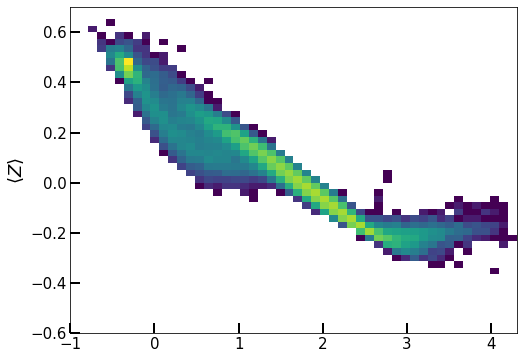

In [215]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

#ax.plot(cdist["nH"][0:len(Gamma_a)], Gamma_a*1.0e21, "-r", linewidth=3, label="silicate, Z=0")
#ax.scatter(cdist["nH"][0:len(Gamma_a)], Gamma_a*1.0e21)
#ax.hist2d(np.log10(cdist["nH"][0:len(Gamma_a)]), np.log10(Gamma_a), bins=50, norm=LogNorm(), cmap="viridis")
ax.hist2d(np.log10(cdist["nH"]),cdist["zmean"], bins=50, norm=LogNorm(), cmap="viridis", range=[[-1, 4.3],[-0.6, 0.7]])

#ax.set_yscale("log")
#ax.set_xscale("log")

#ax.set_xlabel("a [$\AA$]", fontsize=20)
ax.set_ylabel("$\\langle Z \\rangle$", fontsize=18)

#ax.legend(loc=0, fontsize=18)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")


#ax.set_title("Heating Rate vs grain size, Z=0, G=1.7"%asize, fontsize=18)

fig.show()

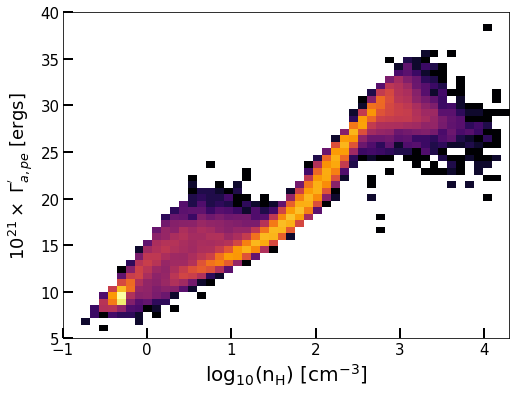

In [226]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

#ax.plot(cdist["nH"][0:len(Gamma_a)], Gamma_a*1.0e21, "-r", linewidth=3, label="silicate, Z=0")
#ax.scatter(cdist["nH"][0:len(Gamma_a)], Gamma_a*1.0e21)
#ax.hist2d(np.log10(cdist["nH"][0:len(Gamma_a)]), np.log10(Gamma_a), bins=50, norm=LogNorm(), cmap="viridis")
ax.hist2d(np.log10(cdist["nH"]),Gamma_a*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 4.3],[5, 40]])

#ax.set_yscale("log")
#ax.set_xscale("log")

ax.set_xlabel("log$_{10}$(n$_{\mathrm{H}}$) [cm$^{-3}$]", fontsize=20)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{'}_{a, pe}$ [ergs]", fontsize=18)

#ax.legend(loc=0, fontsize=18)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")


#ax.set_title("Heating Rate vs grain size, Z=0, G=1.7"%asize, fontsize=18)

fig.show()

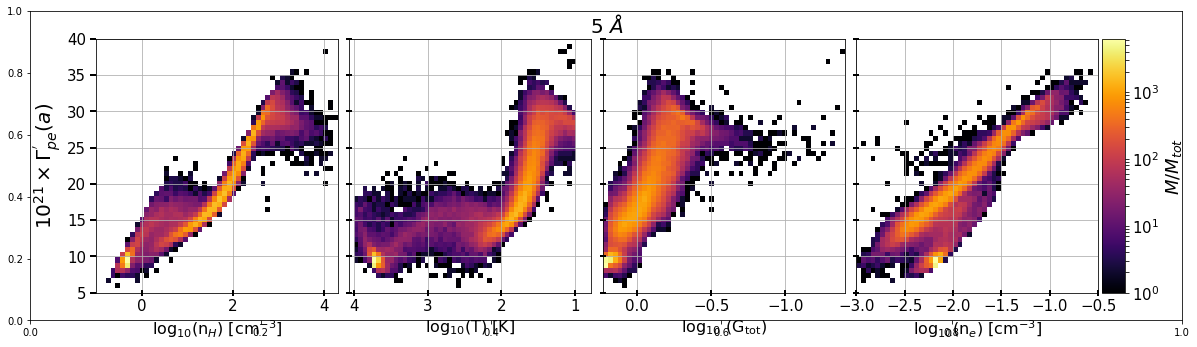

In [270]:
xsize = 16
ysize = 4.3

nfigs_x = 4
nfigs_y = 1

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.09
wpad = 0.057
wwpad = 0.01

xs_panel = 0.84 / nfigs_x 
ys_panel = 0.82 / nfigs_y 

#total_mass = np.sum(cell_mass_int)

############################################################################################################
############################             n          #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

#ax.text(0.18, 0.955, "5 AA", fontsize=20, horizontalalignment='center')

#plt.axis('off')

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0


ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(cdist["nH"]), Gamma_a*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 4.3],[5, 40]])
#ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
#ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    direction= 'inout',
    labelbottom='on') # labels along the bottom edge are off

ax.set_ylabel("$10^{21} \\times \Gamma^{'}_{pe}(a)$", fontsize=20)
ax.set_xlabel("log$_{10}$(n$_{H}$) [cm$^{-3}$]", fontsize=16)

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)


############################################################################################################
############################                T          #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0

ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(cdist["temp"]), Gamma_a*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[1, 4.0],[5, 40]])

#ax.hist2d(np.log10(cdist["temp"][0:len(cell_mass)]), cdist["zstd"][0:len(cell_mass)], bins=50, norm=LogNorm(), cmap="magma", weights=cell_mass/total_mass, vmin=1.0e-6, vmax=1.0e-1)
#ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
#ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    direction= 'inout',
    labelbottom='on', labelleft='off') # labels along the bottom edge are off


ax.set_xlabel("log$_{10}$(T) [K]", fontsize=16)

ax.set_xlim([np.max(np.log10(cdist["temp"])),np.min(np.log10(cdist["temp"]))])

ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)




############################################################################################################
############################               G            #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 0


ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

# Missing G_CR
ax.hist2d(np.log10(cdist["G"]), Gamma_a*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[-1.4, np.log10(1.7)],[5, 40]])

#cax = ax.hist2d(np.log10(cdist["G"][0:len(cell_mass)]+G_CR[0:len(cell_mass)]), cdist["zstd"][0:len(cell_mass)], bins=50, norm=LogNorm(), cmap="magma", weights=cell_mass/total_mass, vmin=1.0e-6, vmax=1.0e-1)
#ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
#ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")


ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    direction= 'inout',
    labelbottom='on', labelleft='off') # labels along the bottom edge are off


ax.set_xlabel("log$_{10}$ (G$_{\\mathrm{tot}}$)", fontsize=16)

#ax.set_xlim([np.log10(1.7),np.min(np.log10(cdist["G"]))])
ax.set_xlim(np.log10(1.7),-1.4)

ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)


############################################################################################################
############################               ne            #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 3
jj = 0


ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(cdist["ne"]), Gamma_a*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[-3, -0.5],[5, 40]])

#Gamma_a*1.0e21, bins=50, norm=LogNorm(), cmap="", weights=cell_mass/total_mass, vmin=1.0e-6, vmax=1.0e-1)
#ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
#ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    direction= 'inout',
    labelbottom='on', labelleft='off') # labels along the bottom edge are off

ax.set_xlabel("log$_{10}$(n$_{e}$) [cm$^{-3}$]", fontsize=16)


ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)



#################################################################################################
# Add colorbar.
cbar_ax = fig.add_axes([0.93, 0.09, 0.02, 0.82])
cbar    = fig.colorbar(cax[3], cax=cbar_ax, orientation="vertical")

cbar.set_label("$M/M_{tot}$", fontsize=18, labelpad=5)
cbar.ax.tick_params(labelsize=15)

fig.suptitle("%i $\\AA$"%(cdist["grain_size"]), fontsize=20, y=0.99)

fig.show()

## Now, integrate over the size distribution

$$ \frac{\Gamma_{tot}}{G n_{\mathrm{H}}} = \sum_{c,s} \int_{a_{min}}^{a_{max}} \frac{\Gamma^{'}_{pe} - \Lambda^{'}_{gr}}{G} \frac{1}{n_{\mathrm{H}}} \frac{dn_{gr}}{da} da $$